<a href="https://colab.research.google.com/github/allansales/classificacao_panelas/blob/main/Classifica%C3%A7%C3%A3o_de_interesse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dependência**
Caso deseje executar o código, antes de começar, por favor, descomente o comando abaixo e instale o pacote **miceforest**.
Após instalação, talvez seja necessário reiniciar o *runtime*.

In [ ]:
#pip install miceforest

# **Introdução**

## **Objetivo**

Neste notebook, nós compararemos dois modelos com relação ao seu desempenho na classificação de produtos como "interessante" ou "não interessante" para o cliente, e indicaremos quais atributos foram mais importantes para a classificação.

## **Estruturação do notebook**

O notebook está dividido em quatro partes:

1.   **Exploração dos dados**. Onde realizaremos analise exploratória inicial da base de dados, isto é, entenderemos como os dados estão estruturados e tomaremos decisões a respeito de possíveis dados ausentes e desbalanceamento de classes;
2.   **Divisão em treino e teste**. Dividiremos a base de dados em base de treino e base de teste, sendo a base de treino utilizado para treinar os modelos desenvolvidos e a base de teste utilizada para comparar os seus resultados;
3.   **Treinar modelos de classificação**. Escolheremos alguns algoritmos de classificação que parecem mais adequados para a tarefa e os tunaremos de acordo com a base de treino;
4.   **Análise dos modelos**. Testaremos os modelos na nossa base de teste, comparando os seus desempenhos e indicando quais features se fizeram mais importantes para a classificação de cada um deles.


## **Exploração dos dados**

Na minha opinião, toda boa análise requer conhecimentodos dos dados com os quais estão sendo lidados e do contexto no qual eles foram gerados.
Por isso, a fim de conhecer os dados, nós realizamos aqui uma análise descritiva superficial dos mesmos.

### **Descrição dos dados**

Após importar os dados, eu tendo a começar qualquer análise descritiva executando alguns comandos básicos:

**shape**: indica a quantidade de dados com a qual estamos trabalhando e quantas informações nós temos sobre cada instância dos dados;

**head**: dá uma ideia superficial de como os dados estão estruturados, quais informações (campos) estão disponíveis, quais relações entre os campos nós podemos já começar a inferir, quais dos campos podem ter valores faltantes, etc;

**describe**: esboça a distribuição dos campos numéricos disponíveis através de estatísticas básicas como média, desvio padrão, valores máximos, mínimos e seus intervalos interquartis. Para campos categóricos, aponta a quantidade de itens e itens unicos, dentre outros;

**value_counts().plot.bar()**: dado uma *Serie*, plota um gráfico de barras indicando a distribuição das classes da base de dados.

A seguir nós executamos os comandos e analisamos as saídas.

Importa dados:

In [ ]:
import pandas as pd
import numpy as np

panelas_data = pd.read_csv("https://raw.githubusercontent.com/allansales/classificacao_panelas/main/problem1_dataset.csv")

In [ ]:
n_panelas, n_informacoes = panelas_data.shape

f'Quantidade de panelas: {n_panelas}. Quantidade de informações sobre cada panela: {n_informacoes}'

'Quantidade de panelas: 180275. Quantidade de informações sobre cada panela: 21'

In [ ]:
panelas_data.head()

,ITEM_ID,ALTURA,CAPACIDADE_(L),COMPOSICAO,COR,FORMATO,LARGURA,MARCA,PARA_LAVA_LOUCAS,PARA_MICRO_ONDAS,PESO,PROFUNDIDADE,TEMPO_GARANTIA,TEM_FERRO_FUNDIDO,TEM_GRELHA,TEM_TAMPA,TIPO_PRODUTO,TIPO_WOK,SESSION_ID,ITEM_PRICE,INTERESTED
0,264220456,30.5,NaN,ALUMINIO,VINHO,NaN,14.0,LA CUISINE,NaN,NaN,NaN,50.0,3.0,NAO,SIM,1.0,PANELA,NAO,86.709770,199.990000,0.0
1,238630912,22.0,NaN,ALUMINIO,COLORIDO,NaN,24.0,TRAMONTINA,No,no,150.0,40.0,12.0,NAO,NAO,1.0,PIPOQUEIRA,NAO,73.156401,105.112581,0.0
2,218228122,24.0,NaN,INOX,INOX,NaN,20.0,LA CUISINE,Yes,no,190.0,20.0,3.0,NAO,NAO,1.0,ESPAGUETEIRA,NAO,952.331024,139.990000,0.0
3,253661510,49.5,6.0,ALUMINIO,VERMELHO,REDONDO,41.5,TRAMONTINA,Yes,NaN,120.0,47.0,NaN,NAO,NAO,1.0,PIPOQUEIRA,NAO,637.759106,103.293333,1.0
4,253661510,49.5,6.0,ALUMINIO,VERMELHO,REDONDO,41.5,TRAMONTINA,Yes,NaN,120.0,47.0,NaN,NAO,NAO,1.0,PIPOQUEIRA,NAO,478.531428,103.330242,0.0


In [ ]:
panelas_data.describe(include='all')

,ITEM_ID,ALTURA,CAPACIDADE_(L),COMPOSICAO,COR,FORMATO,LARGURA,MARCA,PARA_LAVA_LOUCAS,PARA_MICRO_ONDAS,PESO,PROFUNDIDADE,TEMPO_GARANTIA,TEM_FERRO_FUNDIDO,TEM_GRELHA,TEM_TAMPA,TIPO_PRODUTO,TIPO_WOK,SESSION_ID,ITEM_PRICE,INTERESTED
count,1.802750e+05,171007.000000,76671.000000,156978,170251,90011,171007.000000,180001,104086,86402,98524.000000,171007.000000,122770.000000,180275,180275,180275.000000,180275,180275,178273.000000,167178.000000,180275.000000
unique,NaN,NaN,NaN,5,24,5,NaN,35,3,2,NaN,NaN,NaN,2,2,NaN,38,2,NaN,NaN,NaN
top,NaN,NaN,NaN,ALUMINIO,INOX,REDONDO,NaN,TRAMONTINA,Yes,no,NaN,NaN,NaN,NAO,NAO,NaN,PANELA,NAO,NaN,NaN,NaN
freq,NaN,NaN,NaN,114218,34502,79888,NaN,72971,74615,81367,NaN,NaN,NaN,154938,160090,NaN,62418,144820,NaN,NaN,NaN
mean,2.156229e+08,30.575636,4.234668,NaN,NaN,NaN,27.882157,NaN,NaN,NaN,311.259118,34.797386,13.870742,NaN,NaN,0.440704,NaN,NaN,499.757195,127.831019,0.086130
std,1.030257e+08,14.856403,1.699274,NaN,NaN,NaN,10.494943,NaN,NaN,NaN,1727.585999,15.179911,43.641581,NaN,NaN,0.496473,NaN,NaN,288.841689,137.298241,0.280556
min,2.939160e+05,2.000000,0.045000,NaN,NaN,NaN,4.500000,NaN,NaN,NaN,0.619000,2.500000,1.000000,NaN,NaN,0.000000,NaN,NaN,1.011194,0.550000,0.000000
25%,2.273688e+08,19.000000,3.100000,NaN,NaN,NaN,20.000000,NaN,NaN,NaN,120.000000,19.800000,3.000000,NaN,NaN,0.000000,NaN,NaN,249.343773,74.990000,0.000000
50%,2.485863e+08,30.500000,4.500000,NaN,NaN,NaN,27.800000,NaN,NaN,NaN,160.000000,38.500000,6.000000,NaN,NaN,0.000000,NaN,NaN,500.759182,104.482418,0.000000
75%,2.567376e+08,42.700000,6.000000,NaN,NaN,NaN,35.000000,NaN,NaN,NaN,190.000000,47.000000,12.000000,NaN,NaN,1.000000,NaN,NaN,749.204738,146.327727,0.000000


0.0    164748
1.0     15527
Name: INTERESTED, dtype: int64


<AxesSubplot:>

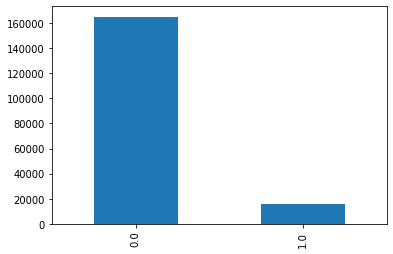

In [ ]:
distribuicao_classes = panelas_data.INTERESTED.value_counts()
print(distribuicao_classes)
distribuicao_classes.plot.bar()

Algumas conclusões sobre a base de dados já podem ser tiradas a partir desses comandos:

1.   A base de dados contém 180275 registros de panelas, com 21 informações sobre cada registro;
2.   A base possui informações com variáveis categóricas (e.g., tem_tampa, tem_grelha), discretas (e.g., tamanho) e contínuas (e.g., peso) sobre cada panela, e algumas das informações categóricas estão dispostas como números (e.g., tem_tampa, interested) enquanto outras estão como *strings* (e.g., marca). 
A depender do modelo que utilizaremos para classificar uma panela como interessante ou não para o cliente, essas informações categóricas precisarão ser transformadas em valores discretos.
Nós separamos uma lista com as informações categóricas e quantitativas abaixo;
3.   Apenas algumas informações estão presentes para todas os registros (e.g., tem_tampa, tem_ferro_fundido). 
Devido essa característica, será necessário investigar qual a melhor alternativa para lidar com os dados faltantes. 
4.   O ITEM_ID e o SESSION_ID parecem se referir a um ID único de identificação de um produto e sessão de um usuário, respectivamente, que não contribuem com a classificação. Por esses motivos, eles serão retirados da análise.
5.   Os dados apresentam desbalancemento severo, com aproximadamente 10x mais registros da classe 0 do que da classe 1, portanto, algumas decisões relacionadas a métrica de avaliação de modelo, algoritmo e *resampling*, precisarão ser tomadas.


In [ ]:
informacoes_categoricas = ["COMPOSICAO","COR","FORMATO","MARCA","PARA_LAVA_LOUCAS","PARA_MICRO_ONDAS","TEM_FERRO_FUNDIDO","TEM_GRELHA","TEM_TAMPA","TIPO_PRODUTO","TIPO_WOK"]
informacoes_quantitativas = ["ITEM_ID","ALTURA","CAPACIDADE_(L)","LARGURA","PESO","PROFUNDIDADE","TEMPO_GARANTIA","SESSION_ID","ITEM_PRICE"]

panelas_data = panelas_data.drop(["ITEM_ID","SESSION_ID"], axis=1)

A seguir, vamos nos aprofundar na análise dos dados faltantes e no desbalanceamento de classes. 
Primeiramente, nós tomamos algumas decisões a respeito do possível problema de desbalanceamento de classes que enfretamos.
Em seguida, nós vamos apontar estratégias que podem ser adotadas para tratar os dados faltantes e vamos avaliá-las com base nas suas características e no reflexo que cada uma delas provoca no desbalanceamento das classes.

#### **Lidando com desbalanceamento de classes**

Nossa base de dados apresenta um desbalancemento de classes severo, sendo aproximadamente 92% dos registros pertencentes à classe 0 e 8% à classe 1.
Um desbalanceamento severo pode enviesar o modelo de classificação, o fazendo classificar novas entradas como instâncias, principalmente, da classe majoritária.
A seguir listamos alguns cuidados devem ser tomados ao trabalharmos com dados desbalanceados e o que faremos a respeito das mesmas para solucionar nosso problema:
1.   Utilizar métricas de avaliação do modelo de classificação insensíveis, ou pouco sensíveis, ao desbalanceamento. Métricas como a acurácia, por exemplo, se tornam problemáticas em cenários de desbalanceamento severo, já que elas podem apresentar um valor alto mesmo com um modelo que classifica qualquer registro como sendo da classe majoritária. Para esses casos, uma Matriz de Confusão acompanhada de métricas de Precisão, Recall e F-measure são mais indicadas e serão adotadas aqui;
2.   Utilizar algoritmos que lidam bem com o desbalanceamento. A Árvore de Decisão, por exemplo, é um algoritmo conhecido por performar bem nesses cenários, muito provavelmente em razão de criar regras que separem bem as classes. 
Devido a esse motivo, nós estaremos adotando a Árvore de Decisão para realizarmos a classificação.
Outros métodos baseados em Árvore de Decisão, como a Floresta Aleatória, também poderiam ser utilizados aqui com possíveis ganhos de performance. A Árvore de Decisão será adotado para acelerar o treinamento dos modelos;
3.   Aumentar a penalização dos erros da classe minoritária. Alguns algoritmos permitem ser configurados com pesos que os penalizam mais por um erro de uma classe que de outra. Assim, em algumas situções pode ser interessante treinar o algoritmo explicitando que o erro de classificação da classe minoritária é x vezes mais prejudicial que o da majoritária. Nós utilizaremos a implementação de Árvore de Decisão do sklearn, que permite o ajuste de pesos para cada classe;
4.   Utilizar técnicas de *Resampling* (*Oversampling* e *Undersampling*) para balancear os dados. *Oversampling* se refere à adição de instâncias da classe minoritária na base de dados, enquanto *Undersampling* se refere a remoção, aleatória ou por algoritmos de classificação, de instâncias da classe majoritária.
Técnicas de *Oversampling* podem envolver repetição de dados existentes, *bootstraping* ou criação de dados sintéticos, sendo o SMOTE uma das técnicas mais populares de criação de dados sintéticos. 
Nós investigaremos qual é a melhor solução para o problema executando experimentos para comparar diferentes estratégias: (i) utilizar apenas *Undersampling*, (ii) utilizar apenas o *Oversampling*, através do SMOTE, ou (iii) não balancear os dados.

##### **Conclusão**

Devido ao desbalanceamento severo das classes, algumas decisões para os próximos passos já precisaram ser tomadas de agora.
No entanto, apesar de já termos algumas decisões tomadas (e.g., adoção de Árvores de Decisão para treinar o modelo), alguns experimentos com técnicas de *resampling* ainda precisam ser executados para indicarmos com confiança qual é a melhor solução final.
Na seção em que criamos as bases de treino e teste, nós fazemos uso das técnicas de *resampling*.
 


#### **Análise de dados ausentes**

Existem diferentes estratégias para lidar com dados ausentes que são baseadas no princípio de descarte de registros incompletos ou imputação de dados ausentes.
Discutiremos uma por vez, começanco pelo descarte de dados.

##### **Descarte de dados**
Para descartar dados ausentes nós temos as seguintes opções. que chamamos de *Listwise* e *Drop variables*: 
- **Listwise**. Descarte de todo registro que não apresenta todas as informações na base de dados;
- **Drop variables**. Utilização apenas de registros com informação completa após descartar colunas que contém informações menos importantes e muitos dados ausentes.

A opção *Listwise* carrega consigo a desvantagem, principalmente em cenários com muitas variáveis, de o número de descartes ser muito alto e ocasionalmente resultar em dados enviesados, considerando que os dados não sejam faltantes por motivos completamente randômicos.
A opção *Drop variables*, por sua vez, necessita de que uma informação apresente grande parcela de dados faltantes (e.g., mais de 50%) e ainda a decisão, preferencialmente de um especialista do contexto, indicando quais informações são importantes de manter e quais podem ser descartadas.
Abaixo, primeiramente, nós calculamos a porcentagem de dados ausentes para cada informação da tabela, e logo após, mostramos os resultados das diferentes abordagens, também verificando as suas influencias no balanceamento das classes.



In [ ]:
# calculo de porcentagem de dados faltantes para cada informção presente no datase
porcent_faltantes_por_info = panelas_data.isna().sum()/n_panelas
print("Porcentagem de dados ausentes para cada informação (coluna):")
print(porcent_faltantes_por_info)

Porcentagem de dados ausentes para cada informação (coluna):
ALTURA               0.051410
CAPACIDADE_(L)       0.574700
COMPOSICAO           0.129230
COR                  0.055604
FORMATO              0.500702
LARGURA              0.051410
MARCA                0.001520
PARA_LAVA_LOUCAS     0.422627
PARA_MICRO_ONDAS     0.520721
PESO                 0.453479
PROFUNDIDADE         0.051410
TEMPO_GARANTIA       0.318985
TEM_FERRO_FUNDIDO    0.000000
TEM_GRELHA           0.000000
TEM_TAMPA            0.000000
TIPO_PRODUTO         0.000000
TIPO_WOK             0.000000
ITEM_PRICE           0.072650
INTERESTED           0.000000
dtype: float64


###### **Abordagem listwise**

In [ ]:
# descartar qualquer registro incompleto (listwise)
descarte_registro_incompleto = panelas_data.dropna()
print(descarte_registro_incompleto.shape)

descarte_registro_incompleto.describe(include='all')

(27564, 19)


,ALTURA,CAPACIDADE_(L),COMPOSICAO,COR,FORMATO,LARGURA,MARCA,PARA_LAVA_LOUCAS,PARA_MICRO_ONDAS,PESO,PROFUNDIDADE,TEMPO_GARANTIA,TEM_FERRO_FUNDIDO,TEM_GRELHA,TEM_TAMPA,TIPO_PRODUTO,TIPO_WOK,ITEM_PRICE,INTERESTED
count,27564.000000,27564.000000,27564,27564,27564,27564.000000,27564,27564,27564,27564.000000,27564.000000,27564.000000,27564,27564,27564.000000,27564,27564,27564.000000,27564.000000
unique,NaN,NaN,3,11,1,NaN,9,2,2,NaN,NaN,NaN,2,1,NaN,6,2,NaN,NaN
top,NaN,NaN,ALUMINIO,CEREJA,REDONDO,NaN,TRAMONTINA,Yes,no,NaN,NaN,NaN,NAO,NAO,NaN,PANELA,SIM,NaN,NaN
freq,NaN,NaN,25655,23202,27564,NaN,23732,26853,26577,NaN,NaN,NaN,26854,27564,NaN,25292,23732,NaN,NaN
mean,40.545763,4.319963,NaN,NaN,NaN,32.012491,NaN,NaN,NaN,172.218365,20.161783,11.162966,NaN,NaN,0.032434,NaN,NaN,110.630138,0.086852
std,8.748961,1.025585,NaN,NaN,NaN,4.939193,NaN,NaN,NaN,239.835361,5.031639,5.292976,NaN,NaN,0.177152,NaN,NaN,42.906273,0.281624
min,9.000000,0.750000,NaN,NaN,NaN,11.500000,NaN,NaN,NaN,10.000000,9.500000,1.000000,NaN,NaN,0.000000,NaN,NaN,39.990000,0.000000
25%,42.700000,4.500000,NaN,NaN,NaN,32.700000,NaN,NaN,NaN,160.000000,18.100000,12.000000,NaN,NaN,0.000000,NaN,NaN,94.726667,0.000000
50%,42.700000,4.500000,NaN,NaN,NaN,32.700000,NaN,NaN,NaN,160.000000,18.100000,12.000000,NaN,NaN,0.000000,NaN,NaN,95.997778,0.000000
75%,42.700000,4.500000,NaN,NaN,NaN,32.700000,NaN,NaN,NaN,180.000000,19.800000,12.000000,NaN,NaN,0.000000,NaN,NaN,125.684211,0.000000


<AxesSubplot:>

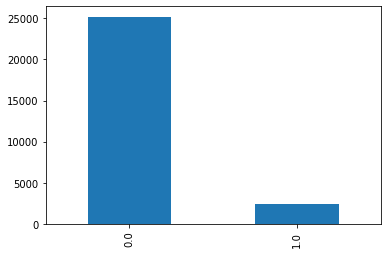

In [ ]:
descarte_registro_incompleto.INTERESTED.value_counts().plot.bar()

###### **Abordagem drop variable**

In [ ]:
# remoção de informações com taxa elevada de dados ausentes
def drop_variable(df, porcentagens_descarte, porcent_descarte):
  n_panelas = df.shape[0]
  a_remover = porcent_faltantes_por_info[porcent_faltantes_por_info > porcent_descarte]
  descarte_informacao = df.drop(axis = 1, labels = a_remover.index).dropna()
  return descarte_informacao, a_remover.index


dados_remanescentes = {}
porcent_faltantes_por_info = panelas_data.isna().sum()/n_panelas
porcentagens_descarte = [0.1,0.2,0.3,0.4,0.5,0.6]
for p in porcentagens_descarte:
  descarte_informacao, a_remover = drop_variable(panelas_data, porcent_faltantes_por_info, p)
  dados_remanescentes[p] = (descarte_informacao.shape, a_remover)

print("Dados remanescentes na base de dados por taxa de dados ausentes:")
print(dados_remanescentes)

Dados remanescentes na base de dados por taxa de dados ausentes:
{0.1: ((151446, 12), Index(['CAPACIDADE_(L)', 'COMPOSICAO', 'FORMATO', 'PARA_LAVA_LOUCAS',
       'PARA_MICRO_ONDAS', 'PESO', 'TEMPO_GARANTIA'],
      dtype='object')), 0.2: ((132909, 13), Index(['CAPACIDADE_(L)', 'FORMATO', 'PARA_LAVA_LOUCAS', 'PARA_MICRO_ONDAS',
       'PESO', 'TEMPO_GARANTIA'],
      dtype='object')), 0.3: ((132909, 13), Index(['CAPACIDADE_(L)', 'FORMATO', 'PARA_LAVA_LOUCAS', 'PARA_MICRO_ONDAS',
       'PESO', 'TEMPO_GARANTIA'],
      dtype='object')), 0.4: ((103068, 14), Index(['CAPACIDADE_(L)', 'FORMATO', 'PARA_LAVA_LOUCAS', 'PARA_MICRO_ONDAS',
       'PESO'],
      dtype='object')), 0.5: ((63417, 16), Index(['CAPACIDADE_(L)', 'FORMATO', 'PARA_MICRO_ONDAS'], dtype='object')), 0.6: ((27564, 19), Index([], dtype='object'))}


               ALTURA COMPOSICAO     COR  ...  TIPO_WOK     ITEM_PRICE     INTERESTED
count   132909.000000     132909  132909  ...    132909  132909.000000  132909.000000
unique            NaN          4      24  ...         2            NaN            NaN
top               NaN   ALUMINIO    INOX  ...       NAO            NaN            NaN
freq              NaN     101142   27291  ...    100892            NaN            NaN
mean        32.288051        NaN     NaN  ...       NaN     125.262816       0.094222
std         14.783900        NaN     NaN  ...       NaN      90.675015       0.292139
min          2.000000        NaN     NaN  ...       NaN       0.550000       0.000000
25%         19.700000        NaN     NaN  ...       NaN      89.990000       0.000000
50%         30.500000        NaN     NaN  ...       NaN     106.098723       0.000000
75%         44.500000        NaN     NaN  ...       NaN     150.302500       0.000000
max         78.250000        NaN     NaN  ...       Na

<AxesSubplot:>

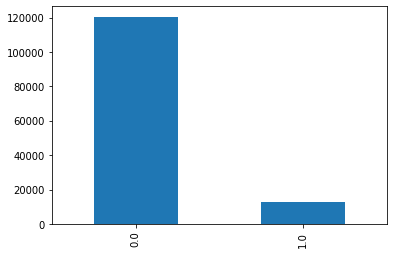

In [ ]:
descarte_informacao, a_remover = drop_variable(panelas_data, porcent_faltantes_por_info, 0.3)
print(descarte_informacao.describe(include="all"))
descarte_informacao.INTERESTED.value_counts().plot.bar()

###### **Conclusão**

Os resultados indicam que ambas abordagens não tem influência significativa na questão do desbalanceamento de classes, que a opção *Listwise* é inviável devido resultar em perdas signicativas de informação (e.g., o número de marcas de panelas decresce de 35 para 9), e que a opção *Drop variables*, mesmo na melhor configuração que consideramos, onde eliminamos informações (colunas) em que 30% dos valores estão ausentes, ainda sofre do mesmo efeito de perda de informação (e.g., o número de marcas decresce de 35 para 26), apesar de que em menor escala.
Além do mais, algumas das colunas que seriam removidas, de acordo com a opção *Drop variables*, poderiam ser importantes para o cliente, como o TEMPO_GARANTIA.



##### **Imputação de dados**

Opções de imputação dos dados passam por técnicas simples de cálculo da média, mediana e moda, ou até mais sofisticadas como interpolação e técnicas baseadas em algoritmos de classificação e regressão, como o *K-Nearest Neighbors* (KNN) e o *Multiple Imputation by Chained Equations* (MICE), dentre outros.
A seguir nós discutimos vantagens e desvantagens das técnicas listadas.

Apesar da média, mediana e moda solucionarem o problema da ausência de dados de forma rápida, elas tem algumas desvantagens, como reduzir a variância dos dados, que dificulta algoritmos de classificação fazerem bom uso dessas *features* na discriminação das classes.
Interpolação, por sua vez, é uma técnica para imputação de valores quantitativos que supõe uma ordenação dos registros, por exemplo, ao longo do tempo e, portanto, não aplicável no contexto atual.

Quanto ao KNN, uma estratégia utilizando o vizinho mais próximo do item para servir de referência para a imputação pode ser adotada.
Isto é, um valor ausente do registro **A** é preenchido com o valor associado ao mesmo campo de **B**, dado que **B** é o vizinho mais próximo de **A**.
Num cenário otimista, todos os registros da tabela terão pelo menos um vizinho mais próximo que se refere a uma cópia dele mesmo (i.e., dois produtos iguals com IDs diferentes) e, portanto, a decisão de imputar os dados seria ideal.
No pior cenário, cada registro da tabela se refere a um produto bastante distinto de todos os outros e, mesmo o vizinho mais próximo retornaria um valor distante do real.
A desvantagem dessa estratégia remete ao tempo de execução do algoritmo KNN, principalmente em dados com alta dimensionalidade, que se torna lenta devido a necessidade de encontrar o vizinho mais próximo para cada registro.
O KNN pode ser executado em até O(n²).
Uma possível análise para revelar se a proposta de utilizar o vizinho mais próximo é factível, desconsiderando a questão do desempenho, seria utilizar os dados disponíveis que estão completos e verificar se existem centenas de pequenos grupos de produtos repetidos (i.e., registros repetidos, desconsiderando o ITEM_ID, e possivelmente o ITEM_PRICE).

Assim como o KNN, o MICE é um metodo baseado em algoritmos de classificação e regressão (aqui, utilizamos árvore de decisão).
No entanto, ele apresenta diversas vantagens em relação aos demais métodos de imputação mais sofisticados: o MICE é barato computacionalmente, não força o programador a lidar com hiperparâmetros e ainda pode retornar valores de *feature importance*, se necessário.
Por todas as vantagens e desvantagens de cada método listada, nós executamos o MICE sobre os nossos dados.

A seguir, é realizada a conversão das valores categóricos em *One-Hot Encodings* e, logo após, a imputação dos valores com MICE.
Perceba que quando fazemos a transformação das informações categóricas em *One-Hot Encodings*, nós perdemos noção de quais valores eram ausentes (i.e., NaN) na base, ou seja, uma informação ausente de um registro apresentará valor 0 ao invés de valor NaN. 
Manter rastreio dos NaNs é importante para o caso de querermos estimar os valores categóricos ausentes da tabela.

No problema atual, nós vamos estimar apenas valores quantitativos ausentes, em razão da natureza dos dados com os quais estamos lidando.
Os valores de informações quantitativas ausentes parecem ter relação lógica com outras informações presentes na base de dados, de forma que a estimativa de um valor ausente é facilitada pela presença das demais informações do produto (e.g., estimar a altura do produto baseada na sua capacidade e largura).
As informações qualitativas de forma geral, por outro lado, são independentes das demais variáveis do banco de dados, tornando as suas estimativas provavelmente mais imprecisas (e.g., a cor do produto independe da marca, tamanho, preço, etc).
Uma análise de Informação Mútua poderia ser executada aqui para dar mais suporte à decisão.


###### **Transformação de variáveis categóricas em One-hot Encodings**

In [ ]:
dados_codificados = pd.get_dummies(panelas_data, columns=informacoes_categoricas)

###### **Imputação de valores ausentes com MICE**

- A execução da célula a seguir pode levar alguns minutos (menos de 10).

In [ ]:
# Executa o MICE
import miceforest as mf

# Cria kernel. 
kds = mf.KernelDataSet(dados_codificados, save_all_iterations=True, random_state=0)

# Executa o MICE para 5 iterações
kds.mice(5)

# Retorna os dados completos
dados_completos_codificados = kds.complete_data()


In [ ]:
dados_completos_codificados.head()

,ALTURA,CAPACIDADE_(L),LARGURA,PESO,PROFUNDIDADE,TEMPO_GARANTIA,ITEM_PRICE,INTERESTED,COMPOSICAO_ACO ESMALTADO,COMPOSICAO_ALUMINIO,COMPOSICAO_CERAMICA,COMPOSICAO_INOX,COMPOSICAO_PORCELANA,COR_ACACIA,COR_AMARELO,COR_AZUL,COR_BERINGELA,COR_BRANCO,COR_CEREJA,COR_CHOCOLATE,COR_CINZA,COR_COBRE,COR_COLORIDO,COR_FENDI,COR_GOIABA,COR_GRAFITE,COR_INOX,COR_LARANJA,COR_MARROM,COR_PRATA,COR_PRETO,COR_ROSA,COR_ROXO,COR_TURQUESA,COR_VERDE,COR_VERMELHO,COR_VINHO,FORMATO_FRIGIDEIRA,FORMATO_OVAL,FORMATO_QUADRADO,...,TIPO_PRODUTO_ASSADEIRA,TIPO_PRODUTO_BIFETEIRA,TIPO_PRODUTO_BISTEQUEIRA,TIPO_PRODUTO_BULE,TIPO_PRODUTO_CACAROLA,TIPO_PRODUTO_CALDEIRAO,TIPO_PRODUTO_CANECA/FERVEDOR,TIPO_PRODUTO_CANECO,TIPO_PRODUTO_CHALEIRA,TIPO_PRODUTO_CHAPA,TIPO_PRODUTO_COZI-PASTA,TIPO_PRODUTO_COZI-VAPORE,TIPO_PRODUTO_CREMEIRA,TIPO_PRODUTO_CUMBUCA,TIPO_PRODUTO_CUSCUZEIRA,TIPO_PRODUTO_CUSCUZEIRO,TIPO_PRODUTO_ESPAGUETEIRA,TIPO_PRODUTO_FERVEDOR,TIPO_PRODUTO_FOGAREIRO,TIPO_PRODUTO_FONDUE,TIPO_PRODUTO_FORMA,TIPO_PRODUTO_FORNO,TIPO_PRODUTO_FRIGIDEIRA,TIPO_PRODUTO_FRITADEIRA,TIPO_PRODUTO_GRILL,TIPO_PRODUTO_LEITEIRA,TIPO_PRODUTO_MINI-CACAROLA,TIPO_PRODUTO_OMELETEIRA,TIPO_PRODUTO_PAELLERA,TIPO_PRODUTO_PANELA,TIPO_PRODUTO_PANQUEQUEIRA,TIPO_PRODUTO_PAPEIRO,TIPO_PRODUTO_PIPOQUEIRA,TIPO_PRODUTO_PRENSADOR,TIPO_PRODUTO_SANDUICHEIRA,TIPO_PRODUTO_TAMPA,TIPO_PRODUTO_VAPORELLA,TIPO_PRODUTO_WOK,TIPO_WOK_NAO,TIPO_WOK_SIM
0,30.5,3.6,14.0,480.0,50.0,3.0,199.990000,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
1,22.0,4.2,24.0,150.0,40.0,12.0,105.112581,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2,24.0,3.6,20.0,190.0,20.0,3.0,139.990000,0.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,49.5,6.0,41.5,120.0,47.0,12.0,103.293333,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
4,49.5,6.0,41.5,120.0,47.0,12.0,103.330242,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


###### **Análise de distribuição dos dados**

Dado que houve a inserção de novos valores nos registros da base de dados, e tomando como verdade que os valores ausentes se devem à motivos completamente aletórios, é no mínimo interessante que verifiquemos a distribuição dos valores estimados e os comparemos à distribuição dos valores originais.
Distribuições semelhantes nos dão mais confiança que os valores estimados estão próximos ao valor real da *feature*.

A seguir nós plotamos para cada *feature*, em vermelho, o gráfico de densidade da distribuição original e, em preto, o gráfico da distribuição dos novos valores.
A *feature* referente ao gráfico é indicada abaixo do gráfico.
Em seguida, plotamos o gráfico de importância de cada *feature* para fazer a estimativa de valor das demais.
Por exemplo, vemos que as *features* LARGURA, ALTURA e PROFUNDIDADE tiveram maior importância que as demais para estimar os valores ausentes de ITEM_PRICE.


###### Distribuição dos valores imputados

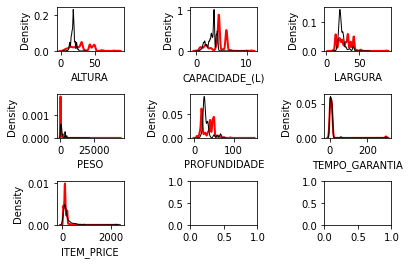

In [ ]:
kds.plot_imputed_distributions(wspace=1, hspace=1)

###### Features mais importantes para imputação

In [ ]:
importancias = kds.get_feature_importance()
nome_features_mais_importantes = [col for col in importancias.columns if (importancias[col] > 0.05).any()]
features_mais_importantes = importancias[nome_features_mais_importantes]

<AxesSubplot:>

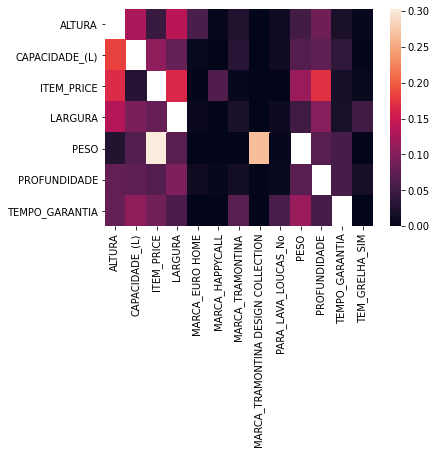

In [ ]:
import seaborn as sns

sns.heatmap(features_mais_importantes)

##### **Conclusão**

Os gráficos de densidade indicam que a distribuição dos valores imputados se assemelham à distribuição dos valores originais, estando os valores estimados dentro da faixa de maior densidade dos valores reais.
A exceção mais evidente se dá na *feature* ALTURA.
No geral, temos uma boa indicação que os valores foram bem estimados pelo modelo.

Por entendermos que as distribuições dos novos dados e dos dados originais se assemelham uma à outra, pela vantagem de não descartarmos informações que podem ser essenciais no momento de classificar um produto como interessante para o cliente, e ainda lembrando que as técnicas de descarte dos dados não resultaram em classes mais balanceadas, nós seguiremos a análise com a base de dados criada a partir da imputação de dados ausentes.

## **Divisão em treino e teste**

O critério de divisão da base de dados em base de treino e teste se relaciona diretamente com o objetivo da análise.
Por exemplo, num problema onde se trabalha com séries temporais, ordenar os registros da base de dados pelo fator tempo é crucial e portanto, uma estratégia como dividir base de treino e teste de forma totalmente aleatória pode ser problemático.
No nosso contexto, por outro lado, onde temos um problema de classificação sem dependência de fatores como o tempo, essa divisão de aleatória de treino e teste é ideal e benéfica por diminuir a chance de estarmos enviesando o modelo por seguir algum critério.

Quanto à proporção da base destinada ao treino e ao teste, usualmente se utiliza valores entre 60/40% e 90/10% da base para treino e teste, respectivamente.
Nós vamos adotar os valores de **67%** para treino e **33%** para teste.

Abaixo, nós separamos a variável alvo (**INTERESTED**) das demais variáveis independentes e fazemos a divisão das bases de treino e teste.
A fim de investigar qual é a melhor abordagem de *resampling* para o nosso problema, a base de treino será criada de três formas distintas: 1) sem ter suas classes balanceadas, 2) balanceando as classes através de técnicas de *Oversampling*, e 3) balanceando as classes através de *Undersampling*.

Dentre as técnicas disponíveis de *Oversampling*, nós escolhemos utilizar o SMOTE, enquanto para *Undersampling*, nós utilizamos o Tomek Link associado ao *Random Undersampling*.
O SMOTE baseia-se em registros originais dos dados para criar registros sintéticos semelhantes aos originais. A sua vantagem em relação ao método de *Random Oversampling* é que o random apenas duplica algumas instâncias da base de dados, possibilitando o enviesamento do modelo que for treinado usando esses dados enquanto o SMOTE cria novos registros únicos.
O Tomek Link é um método de *Undersampling* que busca facilitar a separação dos registros das diferentes classes a partir da remoção de pares de registros de classes diferentes que estão muito próximos um do outro.
Já o *Random Undersampling* remove registros da classe majoritária aleatóriamente até a base de dados estar divida igualmente entre as classes.

Outras estratégias de *Oversampling* e *Undersampling*, ou mesmo a combinação de ambas técnicas, também poderiam ser utilizadas. 
Por exemplo, poderíamos ter feito *Undersampling* a partir da eliminação de registros da classe majoritária que apresentaram algum valor ausente.
Apesar das demais estratégias serem válidas, nós acreditamos que os seus resultados não diferem significativamente das que seguiremos.
Assim, para não alongar demais a análise, nós vamos seguir apenas com as estratégias propostas anteriormente.


### **Sem aplicação de técnicas de balanceamento**


In [ ]:
from sklearn.model_selection import train_test_split

y = dados_completos_codificados.INTERESTED
X = dados_completos_codificados.drop("INTERESTED", axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)

In [ ]:
y_train.value_counts()

0.0    110381
1.0     10403
Name: INTERESTED, dtype: int64

### **Aplicação de Oversampling**

In [ ]:
from imblearn.over_sampling import SMOTE 
from collections import Counter

sm = SMOTE(random_state=2, sampling_strategy="minority")
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train)

print("========")
print('Registros pós Oversampling com SMOTE: %s' % Counter(y_SMOTE))
print("========")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Registros pós Oversampling com SMOTE: Counter({0.0: 110381, 1.0: 110381})


### **Aplicação de Undersampling**

In [ ]:
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler

tl = TomekLinks(random_state=3)
X_tl, y_tl = tl.fit_resample(X_train, y_train)

ru = RandomUnderSampler(random_state=4)
X_under, y_under = ru.fit_resample(X_tl, y_tl)

print("========")
print('Registros pós Undersampling com TomekLink e Random Undersampling: %s' % Counter(y_under))
print("========")

Registros pós Undersampling com TomekLink e Random Undersampling: Counter({0.0: 10403, 1.0: 10403})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## **Treinar modelos de classificação**

Nesta etapa nós estaremos treinando um modelo de Àrvore de Decisão para cada uma das bases de treino criadas na etapa anterior.
Lembrando que a Árvore de Decisão foi o algoritmo escolhido para esta etapa devido lidar bem com dados desbalanceados.
Mas, além disso, ela também tem a vantagem de ser um modelo interpretável, que facilitará o entendimento dos atributos que impulsionam o interesse por um produto.

Para cada modelo treinado, nós fazemos o *tuning* do hiperparâtro *max_depth*, reponsável por definir um valor máximo de profundidade das árvores de decisão, através da técnica *cross validation*.
É importante salientar que nós estamos fazendo o *tuning* de apenas um hiperparâmetro para demonstrar a motivação do *cross validation* e executar o treinamento do modelo rapidamente. 
No entanto, num cenário real, seria necessário tunar os demais hiperparâmetros da árvore.
O método **GridSearchCV** serviria para esse propósito.

A seguir, nós treinamos os modelos, definimos o melhor valor de *max_depth* para cada um e, logo após, testamos os modelos na base de teste.

### **Treinamento e tuning dos modelos**

Nas figuras abaixo, nós apresentamos os valores de F-measure, Precision e Recall atingidos durante o *cross validation* para as diferentes estratégias de balanceamento de dados e valor de *max_depth*.
Quanto maior o valor das métricas, maior a chance daquele *setting* do modelo performar bem no conjunto de testes. 
Portanto, o *setting* de cada modelo que apresentar maior valor das métricas será escolhido para seguir adiante e ser executado no conjunto de testes.


In [ ]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

max_depth_range_options = [10,20,30,40,50,60,70,80,90,100]
scoring = ['precision', 'recall','f1']

def get_metricas_treino(X, y):
  precisions = []
  recalls = []
  f1s = []
  for md in max_depth_range_options:
    #rf = RandomForestClassifier(n_estimators=1, max_depth=md, random_state=1)
    rf = DecisionTreeClassifier(max_depth=md, random_state=1, criterion="entropy")
    scores = cross_validate(rf, X, y, scoring=scoring, cv=2)
    precisions.append(scores['test_precision'])
    recalls.append(scores['test_recall'])
    f1s.append(scores['test_f1'])
  return precisions, recalls, f1s

def desmembra_lista(metrica_list):
  pos0s = []
  pos1s = []
  for pos0, pos1 in metrica_list:
    pos0s.append(pos0)
    pos1s.append(pos1)
  return pos0s, pos1s

def plot_grafico_validacao_depth(max_depth_range_options, precisions, recalls, f1s):
  precision0s, precision1s = desmembra_lista(precisions)
  recall0s, recall1s = desmembra_lista(recalls)
  f10s, f11s = desmembra_lista(f1s)

  plt.title("Curva de valicação da Floresta Aleatória")
  plt.xlabel("max_depth")
  plt.ylabel("Valor")
  plt.plot(max_depth_range_options, precision0s, label="precisão 0")
  plt.plot(max_depth_range_options, precision1s, label="precisão 1")
  plt.plot(max_depth_range_options, recall0s, label="recall 0")
  plt.plot(max_depth_range_options, recall1s, label="recall 1")
  plt.plot(max_depth_range_options, f10s, label="F1 0")
  plt.plot(max_depth_range_options, f11s, label="F1 1")
  plt.legend()

#### **Sem balanceamento**

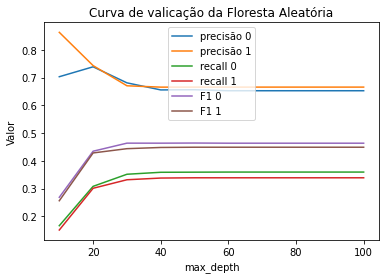

In [ ]:
precisions_train, recalls_train, f1s_train = get_metricas_treino(X_train, y_train)
plot_grafico_validacao_depth(max_depth_range_options, precisions_train, recalls_train, f1s_train)

#### **Conjunto com Oversampling**

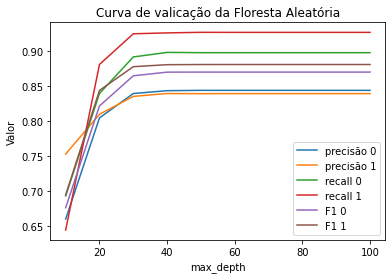

In [ ]:
precisions_SMOTE, recalls_SMOTE, f1s_SMOTE = get_metricas_treino(X_SMOTE, y_SMOTE)
plot_grafico_validacao_depth(max_depth_range_options, precisions_SMOTE, recalls_SMOTE, f1s_SMOTE)

#### **Conjunto com Undersampling**


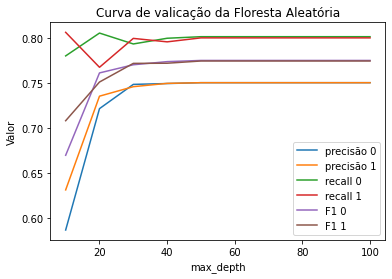

In [ ]:
precisions_under, recalls_under, f1s_under = get_metricas_treino(X_under, y_under)
plot_grafico_validacao_depth(max_depth_range_options, precisions_under, recalls_under, f1s_under)

#### **Conclusão**

Os resultados indicam que, coincidentemente, independente da estratégia, o valor de *max_depth* igual a **30** apresentou os maiores valores de F-measure.
O *max_depth* de **30** será utilizado para treinar o modelo que vamos testar no conjunto de testes.

Aqui, ainda devemos frizar que os resultados dos modelos durante o treino ainda não são comparáveis entre si devido essas métricas estarem sendo geradas a partir de diferentes conjuntos de treino.
Nós poderemos comparar os desempenhos dos modelos gerados pelas diferentes estratégias de balanceamento ao os executarmos sobre o conjunto de testes.


In [ ]:
rfs_train = DecisionTreeClassifier(max_depth=30, random_state=1, criterion="entropy")
rfs_train.fit(X_train, y_train)

rfs_SMOTE = DecisionTreeClassifier(max_depth=30, random_state=1, criterion="entropy")
rfs_SMOTE.fit(X_SMOTE, y_SMOTE)

rfs_under = DecisionTreeClassifier(max_depth=30, random_state=1, criterion="entropy")
rfs_under.fit(X_under, y_under)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

## **Análise dos modelos**

Nesta fase nós utilizamos o conjunto de testes para comparar os modelos treinados, nas diferentes abordagens de balanceamento, com os melhores *settings* em termos de recall, precision e F1.
Além disso, nós fazemos a análise de importância dos atributos que mais impulsionam o interesse do cliente.


### **Análise de desempenho**

Abaixo se encontram um gráfico de barras acompanhado da matriz de confusão indicando o desempenho do modelo de cada abordagem sobre o conjunto de testes.


In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

def get_metricas_teste(modelo):
  predicoes = modelo.predict(X_test)
  recall = recall_score(y_test, predicoes)
  precision = precision_score(y_test, predicoes)
  f1 = f1_score(y_test, predicoes)
  return precision, recall, f1
  
metricas_train = get_metricas_teste(rfs_train)
metricas_SMOTE = get_metricas_teste(rfs_SMOTE)
metricas_under = get_metricas_teste(rfs_under)

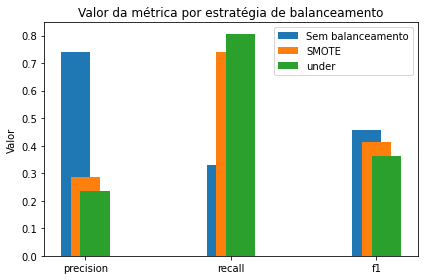

In [ ]:
x = np.arange(len(scoring)) 
width = 0.2  # o width das barras

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/3, metricas_train, width, label='Sem balanceamento')
rects2 = ax.bar(x, metricas_SMOTE, width, label='SMOTE')
rects3 = ax.bar(x + width/3, metricas_under, width, label='under')

ax.set_ylabel('Valor')
ax.set_title('Valor da métrica por estratégia de balanceamento')
ax.set_xticks(x)
ax.set_xticklabels(scoring)
ax.legend()

fig.tight_layout()

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_matriz_confusao(modelo):
  predicoes = modelo.predict(X_test)
  cm = confusion_matrix(y_test, predicoes)

  predito = ["não interessado (pred)", "interessado (pred)"]
  real = ["não interessado (real) ", "interessado (real)"]          

  fig, ax = plt.subplots()
  im = ax.imshow(cm)

  ax.set_xticks(np.arange(len(predito)))
  ax.set_yticks(np.arange(len(real)))

  ax.set_xticklabels(predito)
  ax.set_yticklabels(real)

  plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

  for i in range(len(real)):
      for j in range(len(predito)):
          text = ax.text(j, i, cm[i, j], ha="center", va="center", color="w")

  ax.set_title("Real x Predito")
  plt.show()

#### **Matriz de confusão - Sem balanceamento**

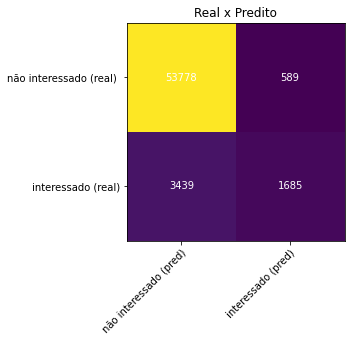

In [ ]:
mc_train = plot_matriz_confusao(rfs_train)

#### **Matriz de confusão - Conjunto com Oversampling**

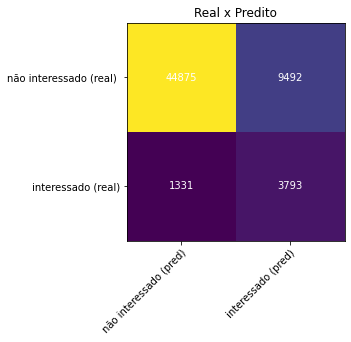

In [ ]:
mc_SMOTE = plot_matriz_confusao(rfs_SMOTE)

#### **Matriz de confusão - Conjunto com Undersampling**

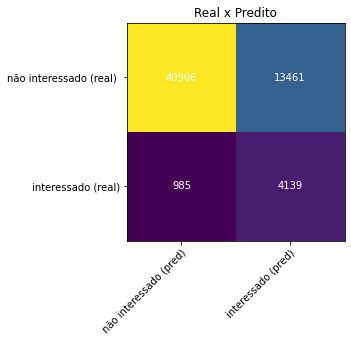

In [ ]:
mc_under = plot_matriz_confusao(rfs_under)

#### **Conclusão**

Os resultados indicam que as diferentes estratégias de balanceamento de dados influenciaram os valores de recall, precision e F1 de formas diferentes.
O modelo que não foi balanceado apresenta o maior valor de precision, embora com baixo recall. O precision alto se dá pela quantidade de verdadeiros positivos encontrados, principalmente da classe majoritária (registros de não interesse no produto). Já o recall baixo reflete a dificuldade em recuperar grande parte da classe minoritária (registros de interesse no produto).

Os modelos balanceados (i.e., *Oversampling* e *Undersampling*) apresentam resultados semelhantes entre si e inversos ao modelo não balanceado: alto recall com baixa precision, sendo o modelo baseado em *Undersampling* o que apresenta o maior recall e o de *Oversampling* o maior precision.
Esses modelos recuperam com sucesso bastante casos da classe minoritária com o custo de errar a classificação de casos da classe majoritária.
Em termos de F1, os três modelos dispõem de resultados semelhantes.

No mundo real, apenas um dos modelos poderia ir pra produção, sendo a escolha do modelo provavelmente relacionada ao valor que os resultados dele trazem para a empresa e no *trade-off* entre precision e recall.
Uma precision alta indica que as classificações de uma classe de interesse tendem a estar corretas, mesmo que nós identifiquemos poucos casos da classe de interesse dentre a quantidade total de casos classificados.
Um recall alto, em contrapartida, indica que estamos identificando muitos casos de interesse dentre o total de casos, mesmo que estejamos também errando algumas classificações de interesse (e.g., classificando um registro como sendo de interesse quando ela, na verdade, não é).
Considerando que, no contexto que estamos trabalhando, o recall seja uma métrica mais importante que o precision, devido querermos identificar o máximo de sessões em que o cliente pode estar interessado num produto, o modelo baseado em *Undersampling* seria o escolhido para ser executado em produção e é a abordagem que utilizaremos para analisar os atributos que mais impulsionam o interesse do cliente. 


### **Análise de atributos importantes para o interesse**

Nesta seção, nós verificamos quais *features* foram mais importantes para a classificação de uma sessão como "interesse" ou "não interesse" num produto.
Abaixo apresentamos um gráfico de barras indicando as importâncias de cada *feature* e os primeiros nós da nossa árvore de decisão, em forma gráfica e em texto, onde podemos identificar o valor utilizado para dividir os registros.


In [ ]:
from sklearn.tree import plot_tree
from sklearn.tree import export_text

def plot_importancia(modelo, n_features):
  df = pd.DataFrame({"importancia":modelo.feature_importances_}, index=X_train.columns)
  df = df.sort_values(by="importancia",ascending=False).head(n_features)
  df.plot.barh()

def plot_arvore(modelo, max_depth):
  from matplotlib.pyplot import figure
  figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
  plot_tree(modelo, max_depth = max_depth, feature_names = X_train.columns)

def plot_arvore_texto(modelo, max_depth):
  print(export_text(modelo, max_depth=max_depth, show_weights=True, feature_names=X_train.columns.array))

#### **Features mais importantes**

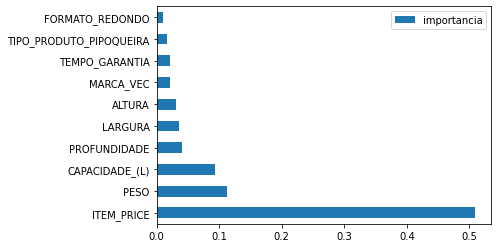

In [ ]:
plot_importancia(rfs_under, 10)

O ITEM_PRICE é a *feature* mais importante para impulsionar o interesse dos clientes, apresentando valor de importâcia, para a classificação, superior a 0.5.
Em seguida, aparecem PESO, CAPACIDADE_(L), PROFUNDIDADE, LARGURA, ALTURA, respectivamente, que somados contribuem com mais aproximadamente 0.3 de importância.
O modelo indica, portanto, que as *features* quantitativas tiveram peso significativamente maior que as categóricas para classificar uma sessão como em interesse no produto.


#### **Valores que mais impulsionam o interesse**

Uma forma de verificar o valor das *features* que divide as sessões com possíveis interessados de não interessados é checar as regras que foram usadas na construção da árvore de decisão.
Abaixo nós plotamos parte da árvore de decisão indicando os valores e as regras que foram utilizadas.


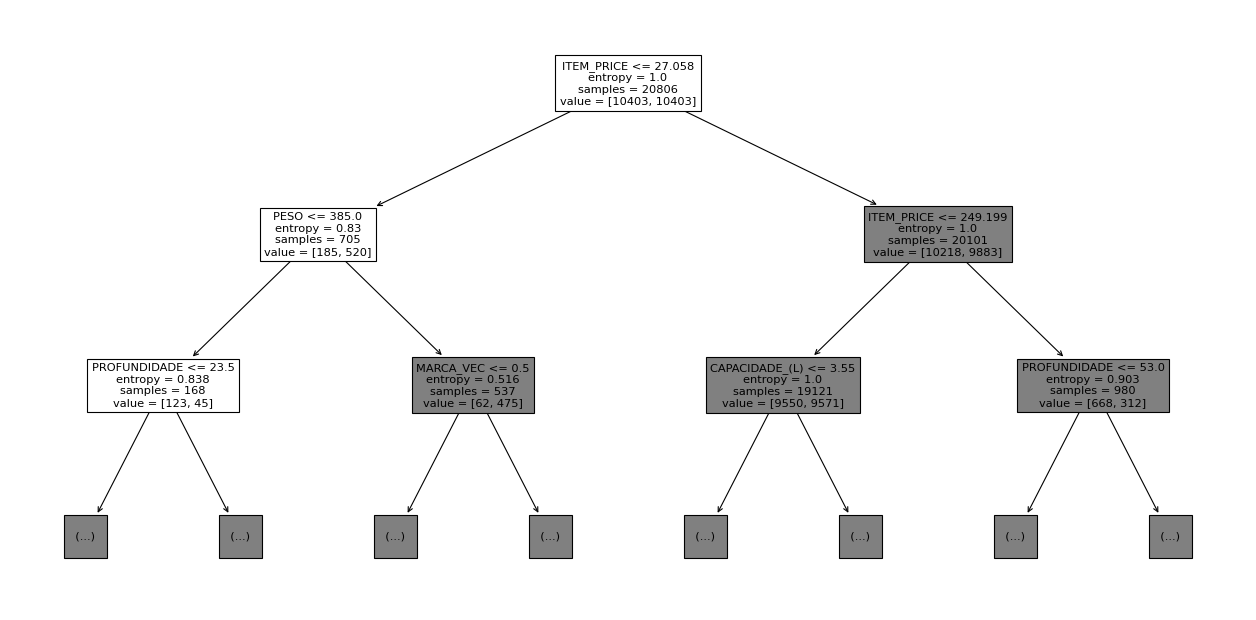

In [ ]:
plot_arvore(rfs_under, 2)

In [ ]:
plot_arvore_texto(rfs_under,3)

|--- ITEM_PRICE <= 27.06
|   |--- PESO <= 385.00
|   |   |--- PROFUNDIDADE <= 23.50
|   |   |   |--- CAPACIDADE_(L) <= 1.82
|   |   |   |   |--- truncated branch of depth 4
|   |   |   |--- CAPACIDADE_(L) >  1.82
|   |   |   |   |--- weights: [0.00, 3.00] class: 1.0
|   |   |--- PROFUNDIDADE >  23.50
|   |   |   |--- CAPACIDADE_(L) <= 2.85
|   |   |   |   |--- truncated branch of depth 7
|   |   |   |--- CAPACIDADE_(L) >  2.85
|   |   |   |   |--- weights: [0.00, 8.00] class: 1.0
|   |--- PESO >  385.00
|   |   |--- MARCA_VEC <= 0.50
|   |   |   |--- MARCA_BRINOX <= 0.50
|   |   |   |   |--- truncated branch of depth 8
|   |   |   |--- MARCA_BRINOX >  0.50
|   |   |   |   |--- truncated branch of depth 13
|   |   |--- MARCA_VEC >  0.50
|   |   |   |--- weights: [0.00, 392.00] class: 1.0
|--- ITEM_PRICE >  27.06
|   |--- ITEM_PRICE <= 249.20
|   |   |--- CAPACIDADE_(L) <= 3.55
|   |   |   |--- ITEM_PRICE <= 180.26
|   |   |   |   |--- truncated branch of depth 27
|   |   |   |--- ITEM_P

Rapidamente é possível identificar, por exemplo, que o número de sessões com interesse no produto se torna maior que o número de não interesados a medida que o ITEM_PRICE diminui.
Na árvore, nota-se o maior número de interessados que de não interessados quando se filtra os registros com ITEM_PRICE menor que 27.
Ao mesmo tempo, quando se filtra registros com ITEM_PRICE maior que 249, o número de não interessados chega ao dobro do de interessados.

Análises semelhantes podem ser realizadas para as *features*.

#### **Comparação de importância de features com os demais modelos**
A título de curiosidade, vamos verificar quais são as features mais importantes para os demais modelos (i.e., sem balanceamento e com *Oversampling*).
Abaixo plotamos as 10 features mais importantes para cada um deles.

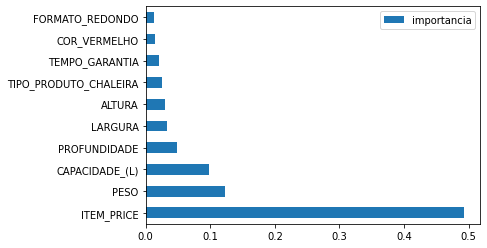

In [ ]:
plot_importancia(rfs_train, 10)

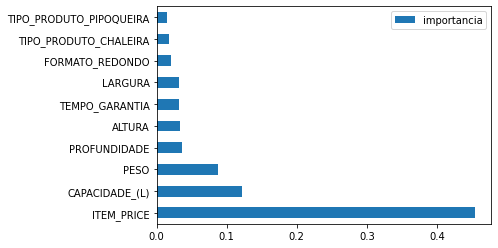

In [ ]:
plot_importancia(rfs_SMOTE, 10)

É fácil perceber que os três modelos concordam que o ITEM_PRICE é a feature mais importante para fazer essa classificação, seguida de PESO E CAPACIDADE_(L), PROFUNDIDADE, ALTURA e LARGURA, com as últimas não necessariamente aparecendo nessa ordem.
TEMPO_GARANTIA aparece com mais importância no modelo de *Oversampling* que nos demais.

## **Discussão de Caminhos Alternativos**

Durante o desenvolvimento desse modelo, nós tomamos várias decisões e explicamos a motivação de cada uma delas.
Ainda assim, há outros caminhos/métodos que poderiam ser testados e nós gostaríamos de destacá-los rapidamente aqui.

1. **Feature Selection**. Nós fizemos análise de importância de *features* após o modelo estar pronto. No entanto, essa análise também poderia ter sido feita previamente à fase de treinamento do modelo, servindo de filtro para identificar *features* que poderiam ser descartados sem trazer prejuízo ao desempenho do modelo. Nós seguimos sem essa análise prévia devido entendermos que o descarte de *features* exige conhecimento de contexto por parte do analista e acreditarmos que não temos o suficiente para fazê-lo ainda.
2. **Normalização dos valores**. Por estarmos utilizando Árvores de Decisão, que não são afetadas por transformações monotônicas, nós não tivemos que nos preocupar com normalização dos valores quantitativos. No entanto, se tivéssemos tomado um caminho diferente, por exemplo, utilizando redes neurais, isso seria necessário.
3. **Redes Neurais**. Redes Neurais são ferramentas fortíssimas e estado-da-arte em diversas tarefas, tais como classificação de texto e imagens. A aplicação de alguma técnica com rede neural poderia ser adotada nessa tarefa também com a finalidade de testar o seu desempenho. Nós descartamos essa alternativa inicialmente por entender que o modelos interpretáveis seriam mais adequados no momento, e que mesmo com ferramentas como o LIME ou SHAP, para fazer a explicação das redes neurais, elas ainda não são tão interpretáveis quanto uma Árvore de Decisão.
Além disso, o custo computacional para treinar uma rede neural é comumente alto.
4. **Teste de hipóteses**. Essa base de dados é rica e pode servir também para fins alternativos ao da classificação que executamos. A aplicação de testes de hipóteses, por exemplo, respondendo perguntas como "O produto da marca X é mais caro que o da marca Y?" pode ter valor para a empresa e para as marcas envolvidas.
